In [1]:
# Parameters to run the code.
mask_shape = "slanted" # Can be "slanted" or "straight"
offset = 20 # Number of pixels from edge of border to ignore
delta_x = 50 # Width of stripes in pixels
total_frames = 185 # Amount of frames considered in the video, maximum is 185
options_delta_frames = [4, 6, 8, 10, 12] # Possible values of delta_frames to consider, used to calculate velocities
stripe_amount = 20 # Amount of stripes to be analyzed

## 1. Generate masks

The following pieces of code create masks that allow for a quick way to check on which stripe a given (x,y) position of a nucleus is.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# get_mask_slanted, get_mask_straight:
# Image, Int, Int -> Array

# Takes an image in its final binary mapping version, that is,
# an image with a black background and a white line of width 1 px,
# which is well defined for all y (each row has exactly one white pixel).

# Returns a numpy array that acts as a mask of the stripes.
# The stripes are defined and indexed from right to left, with an offset
# from the border to avoid noise.

# Each value in the returned matrix is one of the following:
# -2 means background,
# -1 means offset (to avoid noise close to border),
# 0, 1, 2, 3, ... mean the index of the stripe, from right to left.

# mapping_image: image in mapping version, of type Pillow Image
# offset: number of pixels from border to be ignored
# delta_x: pixel width of stripes

### Slanted mask

A slanted mask accounts for the curvature of the border. Every stripe maintains the shape of the border and has a constant width through all its height. The limits of these stripes can be seen as translations of the border to the left.

In [3]:
def get_mask_slanted(mapping_image, offset, delta_x):
    # Convert image to values in array.
    mapping_array = np.array(mapping_image)
    height = mapping_array.shape[0]
    width = mapping_array.shape[1]

    # Initially, mask is completely undefined (-3).
    mask_array = np.full((height, width), -3)

    # Iterate over each row of the image:
    for row in range(height):

        STATE = 'OUTSIDE'
        i = offset
        j = delta_x
        stripe_idx = 0

        # Iterate over each pixel in the row, from right to left:
        for col in reversed(range(width)):

            # While in the background, outside of the tissue.
            if STATE == 'OUTSIDE':
                if mapping_array[row, col] == 0:
                    mask_array[row][col] = -2
                else: # White pixel of border found
                    STATE = 'OFFSET'
                    mask_array[row][col] = -1

            # While inside the offset inside of the tissue.
            elif STATE == 'OFFSET':
                if i > 0:
                    mask_array[row][col] = -1
                    i -= 1
                else: # Offset required width is satisfied
                    STATE = 'STRIPES'
                    mask_array[row][col] = 0

            # While inside an arbitrary stripe inside of the tissue.
            elif STATE == 'STRIPES':
                if j > 0:
                    mask_array[row][col] = stripe_idx
                    j -= 1
                else: # Stripe required width is satisfied
                    stripe_idx += 1
                    mask_array[row][col] = stripe_idx
                    j = delta_x

    return mask_array

### Straight mask

A straight mask does not account for the curvature of the border. Instead, a vertical approximation is used. Every stripe is a rectangle.

In [4]:
def get_mask_straight(mapping_image, offset, delta_x):
    # Convert image to values in array.
    mapping_array = np.array(mapping_image)
    height = mapping_array.shape[0]
    width = mapping_array.shape[1]

    # Find the position of the leftmost white pixel:
    found = False
    lmw_col = -1
    for col in range(width):
        if not found:
            for row in range(height):
                if mapping_array[row, col] != 0:
                    lmw_col = col
                    found = True
                    break

    # Initially, mask is completely undefined (-3).
    mask_array = np.full((height, width), -3)

    # Iterate over each row of the image:
    for row in range(height):

        STATE = 'OUTSIDE'
        i = offset
        j = delta_x
        stripe_idx = 0

        # Iterate over each pixel in the row, from right to left:
        for col in reversed(range(width)):

            # While in the background, outside of the tissue.
            if STATE == 'OUTSIDE':
                if col > lmw_col:
                    mask_array[row][col] = -2
                else: # Border found
                    STATE = 'OFFSET'
                    mask_array[row][col] = -1

            # While inside the offset inside of the tissue.
            elif STATE == 'OFFSET':
                if i > 0:
                    mask_array[row][col] = -1
                    i -= 1
                else: # Offset required width is satisfied
                    STATE = 'STRIPES'
                    mask_array[row][col] = 0

            # While inside an arbitrary stripe inside of the tissue.
            elif STATE == 'STRIPES':
                if j > 0:
                    mask_array[row][col] = stripe_idx
                    j -= 1
                else: # Stripe required width is satisfied
                    stripe_idx += 1
                    mask_array[row][col] = stripe_idx
                    j = delta_x

    return mask_array

### Visualize masks

The following function visualizes the stripes on the given mask array, giving a random color to each of them

In [5]:
# Assigns a random color to each distinct number in a numpy
# matrix and displays the result.
# **This function was completely generated by ChatGPT**
def visualize_mask(mask_array):
    # Generate a random NumPy matrix
    mask_array = mask_array

    # Get the unique numbers in the matrix
    numbers = np.unique(mask_array)

    # Assign a random color to each number
    color_map = {}
    for number in numbers:
        color = np.random.rand(3)
        color_map[number] = color

    # Create a colored image based on the matrix
    image = np.zeros((mask_array.shape[0], mask_array.shape[1], 3))
    for i in range(mask_array.shape[0]):
        for j in range(mask_array.shape[1]):
            number = mask_array[i, j]
            color = color_map[number]
            image[i, j] = color

    # Display the image
    plt.imshow(image)
    plt.axis('off')
    plt.show()

### Save masks

The following script uses the primitive skeletonized version of the border from ImageJ and generates and saves the corresponding mask, using the already defined get_mask function. The first and last masks are shown.

Mask saved in /Users/benjaminalvial/Desktop/Nucleus/cell-jamming/experiment_d/results/csvs_final_mask/final_mask_1_185__1.csv


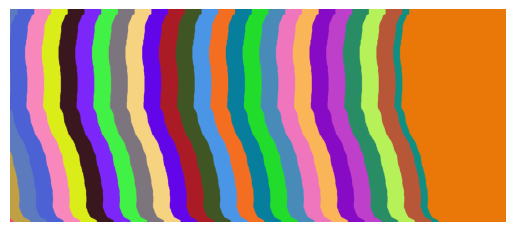

Mask saved in /Users/benjaminalvial/Desktop/Nucleus/cell-jamming/experiment_d/results/csvs_final_mask/final_mask_1_185__2.csv
Mask saved in /Users/benjaminalvial/Desktop/Nucleus/cell-jamming/experiment_d/results/csvs_final_mask/final_mask_1_185__3.csv
Mask saved in /Users/benjaminalvial/Desktop/Nucleus/cell-jamming/experiment_d/results/csvs_final_mask/final_mask_1_185__4.csv
Mask saved in /Users/benjaminalvial/Desktop/Nucleus/cell-jamming/experiment_d/results/csvs_final_mask/final_mask_1_185__5.csv
Mask saved in /Users/benjaminalvial/Desktop/Nucleus/cell-jamming/experiment_d/results/csvs_final_mask/final_mask_1_185__6.csv
Mask saved in /Users/benjaminalvial/Desktop/Nucleus/cell-jamming/experiment_d/results/csvs_final_mask/final_mask_1_185__7.csv
Mask saved in /Users/benjaminalvial/Desktop/Nucleus/cell-jamming/experiment_d/results/csvs_final_mask/final_mask_1_185__8.csv
Mask saved in /Users/benjaminalvial/Desktop/Nucleus/cell-jamming/experiment_d/results/csvs_final_mask/final_mask_1_185

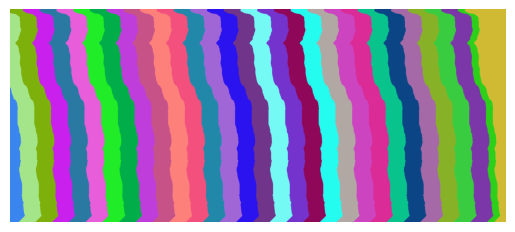

In [6]:
# Given an original skeletonized version of the white border
# on black background from ImageJ, generates and saves the
# 1. binarized version (image)
# 2. mapping version (image)
# 3. mask array (csv)

# In this context, a mapping is an image where EVERY pixel
# in the y dimension (each row) has ONE AND ONLY one white border
# pixel (column) associated in that row.

from PIL import Image
import numpy as np
import os
import pandas as pd

results_border_dir = "/Users/benjaminalvial/Desktop/Nucleus/cell-jamming/experiment_d/results/images_final_border/"
results_binarized_dir = "/Users/benjaminalvial/Desktop/Nucleus/cell-jamming/experiment_d/results/images_final_binarized/"
results_mapping_dir = "/Users/benjaminalvial/Desktop/Nucleus/cell-jamming/experiment_d/results/images_final_mapping/"
results_masks_dir = "/Users/benjaminalvial/Desktop/Nucleus/cell-jamming/experiment_d/results/csvs_final_mask/"

for i in range(1, total_frames+1):
    img_border_name = 'final_border_1_' + str(total_frames) + '__' + str(i) + '.png'
    img_binarized_name = 'final_binarized_1_' + str(total_frames) + '__' + str(i) + '.png'
    img_mapping_name = 'final_mapping_1_' + str(total_frames) + '__' + str(i) + '.png'
    csv_mask_name = 'final_mask_1_' + str(total_frames) + '__' + str(i) + '.csv'

    image = Image.open(os.path.join(results_border_dir, img_border_name)).convert('L')

    # Binarize the image.
    binarized_image = image.point(lambda x: 255 if x > 0 else 0, '1')
    binarized_image.save(os.path.join(results_binarized_dir, img_binarized_name))
    binarized_array = np.array(binarized_image)

    # == One white per row ==
    # Iterate over each row of the image
    for row in range(binarized_array.shape[0]):
        found_white_pixel = False

        # Iterate over each pixel in the row
        for col in range(binarized_array.shape[1]):

            if found_white_pixel:
                if binarized_array[row, col] == True:
                    binarized_array[row, col] = 0

            else:
                if binarized_array[row, col] == True:
                    found_white_pixel = True
    # == == == == == == == ==

    # == Every row has one white ==
    # = Patch upper hole =
    found_uppermost_white_pixel = False
    for row in range(binarized_array.shape[0]):

        # Iterate over each pixel in the row
        for col in range(binarized_array.shape[1]):
            
                if binarized_array[row, col] == True:
                    uppermost_white_pixel_col = col
                    uppermost_white_pixel_row = row
                    found_uppermost_white_pixel = True
                    break

        if found_uppermost_white_pixel:
            break

    for row in range(uppermost_white_pixel_row):
        binarized_array[row, uppermost_white_pixel_col] = 1
    # = = = = = = = =

    # = Patch lower hole =
    found_lowermost_white_pixel = False
    for row in reversed(range(binarized_array.shape[0])):

        # Iterate over each pixel in the row
        for col in range(binarized_array.shape[1]):

                if binarized_array[row, col] == True:
                    lowermost_white_pixel_col = col
                    lowermost_white_pixel_row = row
                    found_lowermost_white_pixel = True
                    break

        if found_lowermost_white_pixel:
            break

    for row in reversed(range(lowermost_white_pixel_row, binarized_array.shape[0])):
        binarized_array[row, lowermost_white_pixel_col] = 1
    # = = = = = = = =
        
    # == == == == == == == ==

    mapping_image = Image.fromarray(binarized_array)
    mapping_image.save(os.path.join(results_mapping_dir, img_mapping_name))
    
    if mask_shape == "slanted":
        mask_array = get_mask_slanted(mapping_image, offset, delta_x)
    elif mask_shape == "straight":
        mask_array = get_mask_straight(mapping_image, offset, delta_x)
        
    np.savetxt(os.path.join(results_masks_dir,csv_mask_name), mask_array, delimiter=',')
    print("Mask saved in "+os.path.join(results_masks_dir,csv_mask_name))

    if i == 1 or i == total_frames:
        visualize_mask(mask_array)

## 2. Generic plotting functions

Two functions are defined to plot how the observables evolve over time.

In [7]:
# DataFrame[frame, index, observable, stdev], String, String, Boolean -> -

# Given a pandas dataframe with columns
# frame, index, observable, stdev located in wdir,
# a plot for each frame is created, with
# the index in the x-axis and the observable in the y-axis
# and the corresponding stdev as error bars if desired.

# The names of the resulting plots are
# observable_001.png, observable_002.png, ...

# Example: plot_by_frame(df, "path/dir", "speed", True)
def plot_by_frame(df, wdir, observable, error_bars):
    
    unique_frames = df['frame'].unique()
    min_obs = df[observable].min()
    max_obs = df[observable].max()
    
    print("Plotting...")
    
    for t in unique_frames:
        
        # Filter the dataframe for the given frame.
        df_filtered = df[df['frame'] == t]
        
        t = int(t)
        zfill_length = len(str(total_frames)) # For all data, should be 3 (digits in 185).
        zfill_str = str(t).zfill(zfill_length)
        
        fig, ax = plt.subplots()
        
        x = df_filtered['index']
        y = df_filtered[observable]
        e = df_filtered['stdev']
        
        if error_bars:
            plt.errorbar(x, y, yerr=e, fmt='o')
        else:
            plt.scatter(x, y)
            
        ax.set_ylim(min_obs, max_obs)
        
        ax.set_xlabel('index')
        ax.set_ylabel(observable)
        plt.title('frame ' + zfill_str)
        
        
        plt.savefig(os.path.join(wdir,observable+"_"+zfill_str))
        plt.close()   
          
    print("Plotting completed.")

In [8]:
# DataFrame[frame, index, observable, stdev], String, String -> -

# Given a pandas dataframe with columns
# frame, index, observable, stdev located in wdir,
# a plot for each stripe is created, with
# the frame in the x-axis and the observable in the y-axis.

# The names of the resulting plots are
# packing_stripe_00.png, packing_stripe_01.png, ...

# Example: plot_by_frame(df, "path/dir", "speed")
def plot_stripe_time_series(df, wdir, observable):
    
    unique_indices = df['index'].unique()
    min_obs = df[observable].min()
    max_obs = df[observable].max()
    
    print("Plotting...")
    
    for i in unique_indices:
        
        # Filter the dataframe for the given frame.
        df_filtered = df[df['index'] == i]
        
        i = int(i)
        zfill_length = len(str(stripe_amount)) # For all data, should be 2 (digits in 20).
        zfill_str = str(i).zfill(zfill_length)
        
        fig, ax = plt.subplots()
        
        x = df_filtered['frame']
        y = df_filtered[observable]
        
        plt.scatter(x,y)
        ax.set_ylim(min_obs, max_obs)
        
        ax.set_xlabel('frame')
        ax.set_ylabel(observable)
        plt.title('stripe index '+str(i))

        plt.savefig(os.path.join(wdir,observable+"_stripe_"+str(i)))
        plt.close()   
          
    print("Plotting completed.")

## 3. Velocity data: speed, module of average normalized velocity

### 3.1 Get velocity data

The following pieces of code allow for the calculation of velocities. These are calculated for different delta_frames. When choosing a value for delta_frames, caution must be taken, as velocities near the end of the video cannot be calculated.

In [9]:
# Given the dataframe extracted from FIJI,
# calculates velocities with a given frame interval,
# and saves it in a dedicated folder for that given time interval.
# FIJI indexes from 0. The result is indexed from 1.

import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd

results_masks_dir = "/Users/benjaminalvial/Desktop/Nucleus/cell-jamming/experiment_d/results/csvs_final_mask/"
csv_dir = "/Users/benjaminalvial/Desktop/Nucleus/cell-jamming/experiment_d/data_extracted/"
csv_name = "half185.csv"

time_resolution = 3/60 # 3 minutes between frames, to hours
space_resolution = 1.5 # 1.5 microns per pixel

# Define delta_frames to calculate velocity between frames. 
# Example: if original video is f1 f2 f3 f4 f5 f6 f7 f8 and delta_frames = 3,
# velocity will be calculated between the following frames f1 f4 f7,
# resulting in a total of 2 velocities located in frames f1 and f4.
# Note that f8 is not taken into account.
def get_velocity_data(delta_frames):
    
    results_data_delta_dir = "/Users/benjaminalvial/Desktop/Nucleus/cell-jamming/experiment_d/data_extracted/velocity_delta/"
    new_csv_name = "velocities_delta_"+str(delta_frames)+".csv"

    df_original = pd.read_csv(os.path.join(csv_dir, csv_name), skiprows=[1, 2, 3])
    df = df_original.copy()
    df = df.sort_values(by=['TRACK_ID', 'FRAME'], ascending=True)
    df = df.reset_index(drop=True)
    df_general = pd.DataFrame(columns=['FRAME','POS_X','POS_Y','VEL_X','VEL_Y','DIFF_T','TRACK_ID'])

    # Iterate over the tracks and generate their dataframe.
    for i in range(0, len(df.TRACK_ID.unique())):
        df_filtered = df[df['TRACK_ID'] == i]
        df_filtered = df_filtered.reset_index(drop=True)
        
        if len(df_filtered) <= delta_frames:
            continue # Do not calculate because it is impossible.

        else:
            # Iterate over the frames (except the last, velocities are undefined here) in the track.
            for j in range(0, len(df_filtered)-delta_frames, delta_frames): # Velocity will be calculated for every frame possible.

                frame = df_filtered['FRAME'][j]
                
                if frame != j:
                    continue

                pos_x = df_filtered['POSITION_X'][j]
                pos_y = df_filtered['POSITION_Y'][j]
                vel_x = (space_resolution/time_resolution) * (1/delta_frames) * (df_filtered['POSITION_X'][j + delta_frames] - df_filtered['POSITION_X'][j])
                vel_y = - (space_resolution/time_resolution) * (1/delta_frames) * (df_filtered['POSITION_Y'][j + delta_frames] - df_filtered['POSITION_Y'][j]) # Fiji inverts y-axis
                diff_t = df_filtered['FRAME'][j + delta_frames] - df_filtered['FRAME'][j]
                track_id = df_filtered['TRACK_ID'][j]

                # Define a tuple to be added to the DataFrame
                new_tuple = (frame+1, pos_x, pos_y, vel_x, vel_y, diff_t, track_id)
                # Add the tuple to the DataFrame
                df_general.loc[len(df_general)] = new_tuple

    df_general.to_csv(os.path.join(results_data_delta_dir, new_csv_name), index=False)

    print("Dataframe created and saved in "+os.path.join(results_data_delta_dir, new_csv_name))
    print(df_general)

In [10]:
for option in options_delta_frames:
    get_velocity_data(delta_frames=option)

Dataframe created and saved in /Users/benjaminalvial/Desktop/Nucleus/cell-jamming/experiment_d/data_extracted/velocity_delta/velocities_delta_4.csv
        FRAME        POS_X       POS_Y      VEL_X      VEL_Y  DIFF_T  TRACK_ID
0         1.0  1114.236909  509.263010  12.966234 -14.546384     4.0       0.0
1         5.0  1115.965740  511.202528  19.322222 -14.346486     4.0       0.0
2         9.0  1118.542036  513.115392   8.944711  -1.876570     4.0       0.0
3        13.0  1119.734664  513.365602   5.950549  -0.306823     4.0       0.0
4        17.0  1120.528071  513.406511   3.273535   0.095825     4.0       0.0
...       ...          ...         ...        ...        ...     ...       ...
112451    1.0   903.809979  103.489863   2.998658 -17.026783     5.0    3563.0
112452    1.0   241.304165  140.272679   7.495454 -11.048531     5.0    3574.0
112453    1.0   698.815510  212.507294  55.432369 -29.237587     5.0    3588.0
112454    1.0   820.790421   28.810070  12.513293  -0.286561  

### 3.2 Calculate observables speed, module of average normalized velocity

In [11]:
# Given the dataframe with the calculated velocities,
# finds the stripe each spot is in to plot speed and module of average normalized velocity for each stripe.

# Formula for speed: 1/N * sum(|vect vj|)
# Formula for module of average normalized velocity: | 1/N * sum((vect j)/|vect j|) |

import pandas as pd
import numpy as np
import os
import math
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import statistics

results_masks_dir = "/Users/benjaminalvial/Desktop/Nucleus/cell-jamming/experiment_d/results/csvs_final_mask/"

def get_velocity_stripes(delta_frames, stripe_amount):

    data_delta_dir = "/Users/benjaminalvial/Desktop/Nucleus/cell-jamming/experiment_d/data_extracted/velocity_delta/"
    data_csv_name = "velocities_delta_"+str(delta_frames)+".csv"
    df_general = pd.read_csv(os.path.join(data_delta_dir, data_csv_name))

    results_plots_speed_dir = "/Users/benjaminalvial/Desktop/Nucleus/cell-jamming/experiment_d/results/plots_speed/speed_delta_" + str(delta_frames)
    results_plots_manv_dir = "/Users/benjaminalvial/Desktop/Nucleus/cell-jamming/experiment_d/results/plots_manv/manv_delta_" + str(delta_frames)
    
    # Speed
    speed_column_names = ['frame', 'index', 'speed', 'stdev']
    speed_df = pd.DataFrame({col: [] for col in speed_column_names})
    
    # Module of average normalized velocity
    manv_column_names = ['frame', 'index', 'manv', 'stdev']
    manv_df = pd.DataFrame({col: [] for col in manv_column_names})

    # Iterate over the frames and generate their dataframe.
    for t in df_general.FRAME.unique():

        t = int(t)
        csv_mask_name = 'final_mask_1_' + str(total_frames) + '__' + str(t) + '.csv'
        mask_array = np.loadtxt(os.path.join(results_masks_dir,csv_mask_name), delimiter=',')

        df_for_frame = df_general[df_general['FRAME'] - t < 0.001]
        df_for_frame = df_for_frame.reset_index(drop=True)

        # Observables will only be calculated for the given amount of stripes.
        # The following are STRIPE LISTS, which are lists with values for each stripe index.
        
        # Speed
        SL_speed = [0] * stripe_amount
        SL_speed_stdev = [0] * stripe_amount
        SL_speed_squares = [0] * stripe_amount # Option A for stdev
        SS_speed = [ [] for _ in range(stripe_amount) ] # Option B for stdev
        
        # Module of average normalized velocity
        SL_manv = [0] * stripe_amount
        SL_vel_x_normalized = [0] * stripe_amount
        SL_vel_y_normalized = [0] * stripe_amount
        
        # Auxiliary lists
        SL_n_spots = [0] * stripe_amount
        
        # Others
        #SL_average_vel_x = [0] * stripe_amount # 1/N * sum(vect vxj)
        #SL_average_vel_y = [0] * stripe_amount # 1/N * sum(vect vyj)
        #SL_average_module_x_vel = [0] * stripe_amount # 1/N * sum(|vect vxj|)
        #SL_average_module_y_vel = [0] * stripe_amount # 1/N * sum(|vect vyj|)
        
        # Iterate over the spots and add each spot's contribution to its stripe's observables.
        for j in range(0, len(df_for_frame)):
            x, y = round(df_for_frame['POS_X'][j]), round(df_for_frame['POS_Y'][j])
            vx, vy = df_for_frame['VEL_X'][j], df_for_frame['VEL_Y'][j]

            # Find the stripe
            if y == 648: 
                continue

            stripe_idx = int(mask_array[y][x])
            
            if stripe_idx < 0 or stripe_idx >= stripe_amount:
                continue

            if math.sqrt(vx**2+vy**2) == 0:
                continue

            # Auxiliary
            SL_n_spots[stripe_idx] += 1
            
            # Speed
            SL_speed[stripe_idx] += math.sqrt(vx**2+vy**2)
            SL_speed_squares[stripe_idx] += vx**2+vy**2 # Option A for stdev
            SS_speed[stripe_idx].append(math.sqrt(vx**2+vy**2)) # Option B for stdev
            
            # Module of average normalized velocity
            SL_vel_x_normalized[stripe_idx] += vx / math.sqrt(vx**2+vy**2)
            SL_vel_y_normalized[stripe_idx] += vy / math.sqrt(vx**2+vy**2)
            
            # Others
            #SL_average_vel_x[stripe_idx] += vx
            #SL_average_vel_y[stripe_idx] += vy
            #SL_average_module_x_vel[stripe_idx] += abs(vx)
            #SL_average_module_y_vel[stripe_idx] += abs(vy)
            

        for k in range(0, len(SL_n_spots)):
            n_spots = SL_n_spots[k]
            
            if n_spots != 0:
                
                # Speed
                SL_speed[k] = SL_speed[k] / n_spots
                SL_speed_squares[k] = SL_speed_squares[k] / n_spots # Option A for stdev
                SL_speed_stdev[k] = math.sqrt(SL_speed_squares[k]-(SL_speed[k])**2) # Option A for stdev, = sqrt(E(X^2)-E^2(X))
                
                # Module of average normalized velocity
                SL_manv[k] = math.sqrt(SL_vel_x_normalized[k]**2 + SL_vel_y_normalized[k]**2) / n_spots
                
                # Others
                #SL_average_vel_x[k] += SL_average_vel_x[k] / n_spots
                #SL_average_vel_y[k] += SL_average_vel_y[k] / n_spots
                #SL_average_module_x_vel[k] = average_module_x_vel[k] / n_spots
                #SL_average_module_y_vel[k] = average_module_y_vel[k] / n_spots
                
        # Create rows in dataframe.
        for k in range(0, len(SL_n_spots)):
            frame = t
            index = k
            
            speed = SL_speed[k]
            speed_stdev_A = SL_speed_stdev[k] # Option A for stdev
            speed_stdev_B = statistics.stdev(SS_speed[k]) # Option B for stdev
            assert(abs(speed_stdev_A - speed_stdev_B) < 0.1) # Options A and B give same result
            speed_stdev = speed_stdev_A # Let's choose A
            speed_df.loc[len(speed_df)] = (t, k, speed, speed_stdev) # Add to dataframe
            
            manv = SL_manv[k]
            manv_df.loc[len(manv_df)] = (t, k, manv, np.NaN) # Add to dataframe
            
            
    speed_df.to_csv(os.path.join(results_plots_speed_dir, 'all_speed.csv'), index=False)
    print("Dataframe saved to " + results_plots_speed_dir)
    print(speed_df)
    
    manv_df.to_csv(os.path.join(results_plots_manv_dir, 'all_manv.csv'), index=False)
    print("Dataframe saved to " + results_plots_manv_dir)
    print(manv_df)

for option in options_delta_frames:
    get_velocity_stripes(option, stripe_amount)

Dataframe saved to /Users/benjaminalvial/Desktop/Nucleus/cell-jamming/experiment_d/results/plots_speed/speed_delta_4
     frame  index      speed      stdev
0      1.0    0.0  16.501232  11.150812
1      1.0    1.0  11.183185   6.131820
2      1.0    2.0  11.313850   6.124094
3      1.0    3.0  12.109856   6.443458
4      1.0    4.0  12.703548   7.629607
..     ...    ...        ...        ...
915  181.0   15.0  14.711310   9.636911
916  181.0   16.0  15.265661  10.013653
917  181.0   17.0  14.564140   9.123349
918  181.0   18.0  14.259227   8.859431
919  181.0   19.0  14.182297   8.636760

[920 rows x 4 columns]
Dataframe saved to /Users/benjaminalvial/Desktop/Nucleus/cell-jamming/experiment_d/results/plots_manv/manv_delta_4
     frame  index      manv  stdev
0      1.0    0.0  0.745191    NaN
1      1.0    1.0  0.553776    NaN
2      1.0    2.0  0.549111    NaN
3      1.0    3.0  0.597557    NaN
4      1.0    4.0  0.623316    NaN
..     ...    ...       ...    ...
915  181.0   15.0  

Plotting the speed observable.

In [12]:
for option in options_delta_frames:
    print('Plotting for delta_frames=' + str(option))
    delta_frames = option
    results_plots_speed_dir = "/Users/benjaminalvial/Desktop/Nucleus/cell-jamming/experiment_d/results/plots_speed/speed_delta_" + str(delta_frames)
    df_speed = pd.read_csv(os.path.join(results_plots_speed_dir, 'all_speed.csv'))
    print(df_speed['speed'].min())
    print(df_speed['speed'].max())
    
    plot_by_frame(df_speed, results_plots_speed_dir, 'speed', True)
    plot_stripe_time_series(df_speed, results_plots_speed_dir, 'speed')
    print('---------')

Plotting for delta_frames=4
9.045050451744268
42.52187580124948
Plotting...
Plotting completed.
Plotting...
Plotting completed.
---------
Plotting for delta_frames=6
8.902764011981652
41.81286010108473
Plotting...
Plotting completed.
Plotting...
Plotting completed.
---------
Plotting for delta_frames=8
8.456899598241588
41.30938278035445
Plotting...
Plotting completed.
Plotting...
Plotting completed.
---------
Plotting for delta_frames=10
8.190312035238264
41.32611121746631
Plotting...
Plotting completed.
Plotting...
Plotting completed.
---------
Plotting for delta_frames=12
7.745832830959324
40.79750967218692
Plotting...
Plotting completed.
Plotting...
Plotting completed.
---------


Plotting the module of average normalized velocity observable.

In [13]:
for option in options_delta_frames:
    print('Plotting for delta_frames=' + str(option))
    delta_frames = option
    results_plots_manv_dir = "/Users/benjaminalvial/Desktop/Nucleus/cell-jamming/experiment_d/results/plots_manv/manv_delta_" + str(delta_frames)
    df_manv = pd.read_csv(os.path.join(results_plots_manv_dir, 'all_manv.csv'))
    print(df_manv['manv'].min())
    print(df_manv['manv'].max())
    
    plot_by_frame(df_manv, results_plots_manv_dir, 'manv', False)
    plot_stripe_time_series(df_manv, results_plots_manv_dir, 'manv')
    print('---------')

Plotting for delta_frames=4
0.0048570825996713
0.9522382327305446
Plotting...
Plotting completed.
Plotting...
Plotting completed.
---------
Plotting for delta_frames=6
0.0104779295389936
0.954263579051655
Plotting...
Plotting completed.
Plotting...
Plotting completed.
---------
Plotting for delta_frames=8
0.0120157162536147
0.9498393416626024
Plotting...
Plotting completed.
Plotting...
Plotting completed.
---------
Plotting for delta_frames=10
0.011059238308103
0.95944332172168
Plotting...
Plotting completed.
Plotting...
Plotting completed.
---------
Plotting for delta_frames=12
0.0072272274572108
0.9712222845851332
Plotting...
Plotting completed.
Plotting...
Plotting completed.
---------


### 3.3 Exponential fits for speed

In [14]:
# WORK IN PROGRESS: REFACTOR EXPONENTIAL FITS FOR SPEEDS

def exponential_func(x, a, b, c):
    return a * np.exp(-b * x) + c

def fit_exponential(data, start_index):
    x = np.arange(len(data))
    y = data[start_index:]
    popt, _ = curve_fit(exponential_func, x[start_index:], y, p0=[17,0.3,14], maxfev=5000)
    return popt

expfit_plots_dir = "/Users/benjaminalvial/Desktop/Nucleus/cell-jamming/experiment_d/results/plots_expfit/expfit_delta_" + str(delta_frames)

## 4. Image data: packing fraction, FRET/CFP ratio

### 4.1 Get image data

The data is exported from ImageJ as an Image Sequence of TIF images.

### 4.2 Calculate observables packing fraction, FRET/CFP ratio

In [15]:
# Reads the png images one by one.
# For each image, iterates over the pixels,
# finding their parent stripe, and calculating packing fraction and average FRET/CFP ratio for each stripe.

import numpy as np
from PIL import Image
import os
import matplotlib.pyplot as plt
import pandas as pd

images_original_dir = "/Users/benjaminalvial/Desktop/Nucleus/cell-jamming/experiment_d/data_extracted/images_original_tif/"
results_masks_dir = "/Users/benjaminalvial/Desktop/Nucleus/cell-jamming/experiment_d/results/csvs_final_mask/"
results_plots_packing_dir = "/Users/benjaminalvial/Desktop/Nucleus/cell-jamming/experiment_d/results/plots_packing/"
results_plots_ratio_dir = "/Users/benjaminalvial/Desktop/Nucleus/cell-jamming/experiment_d/results/plots_ratio/"

# Generates the dataframes for packing fraction and FRET/CFP ratio,
# calculating average values for each stripe, for each frame.
def get_packing_stripes(stripe_amount):
    
    packing_column_names = ['frame', 'index', 'packing', 'stdev']
    packing_df = pd.DataFrame({col: [] for col in packing_column_names})
    
    ratio_column_names = ['frame', 'index', 'ratio', 'stdev']
    ratio_df = pd.DataFrame({col: [] for col in ratio_column_names})
    
    print("Calculating...")

    for t in range(1,total_frames+1):

        img_name = 'frame_' + str(t).zfill(3) + '.tif'
        img = Image.open(os.path.join(images_original_dir, img_name))
        grayscale_image = img.convert("L")
        pixel_data = grayscale_image.load()

        SL_total_pixels = [0] * stripe_amount
        SL_black_pixels = [0] * stripe_amount
        SL_non_black_pixels = [0] * stripe_amount
        SL_packing_fraction = [0] * stripe_amount
        SL_fret_cfp_ratio = [0] * stripe_amount
        SL_fret_cfp_ratio_stdev = [0] * stripe_amount
        SL_grayscale_squares = [0] * stripe_amount

        csv_mask_name = 'final_mask_1_185__' + str(t) + '.csv'
        mask_array = np.loadtxt(os.path.join(results_masks_dir,csv_mask_name), delimiter=',')

        # Iterate over the pixels
        width, height = grayscale_image.size
        for x in range(width):
            for y in range(height):
                # Get the pixel value (grayscale) at the current position.
                pixel_value = pixel_data[x, y]
                # Get the mask index for the given pixel.
                stripe_idx = int(mask_array[y][x])

                if stripe_idx < 0 or stripe_idx >= stripe_amount:
                    continue

                # Check if the pixel is black (0) or non-black (any other value)
                if pixel_value == 0:
                    SL_black_pixels[stripe_idx] += 1
                else:
                    SL_non_black_pixels[stripe_idx] += 1
                    SL_fret_cfp_ratio[stripe_idx] += pixel_value
                    SL_grayscale_squares[stripe_idx] += pixel_value**2

                SL_total_pixels[stripe_idx] += 1

        # Get averages per stripe.
        for k in range(0, len(SL_total_pixels)):
            SL_packing_fraction[k] = SL_non_black_pixels[k] / SL_total_pixels[k]
            SL_fret_cfp_ratio[k] = SL_fret_cfp_ratio[k] / SL_non_black_pixels[k]
            SL_grayscale_squares[k] = SL_grayscale_squares[k] / SL_non_black_pixels[k]
            SL_fret_cfp_ratio_stdev[k] = math.sqrt(SL_grayscale_squares[k]-(SL_fret_cfp_ratio[k])**2)
        
        # Create rows in dataframe.
        for k in range(0, len(SL_total_pixels)):
            frame = t
            index = k
            
            packing = SL_packing_fraction[k]
            packing_df.loc[len(packing_df)] = (t, k, packing, np.NaN)
            
            ratio = SL_fret_cfp_ratio[k]
            ratio_stdev = SL_fret_cfp_ratio_stdev[k]
            ratio_df.loc[len(ratio_df)] = (t, k, ratio, ratio_stdev)
            
    packing_df.to_csv(results_plots_packing_dir + 'all_packing.csv', index=False)
    print("Dataframe saved to " + results_plots_packing_dir)
    print(packing_df)
        
    ratio_df.to_csv(results_plots_ratio_dir + 'all_ratio.csv', index=False)
    print("Dataframe saved to " + results_plots_ratio_dir)
    print(ratio_df)
    
get_packing_stripes(stripe_amount)

Calculating...
Dataframe saved to /Users/benjaminalvial/Desktop/Nucleus/cell-jamming/experiment_d/results/plots_packing/
      frame  index   packing  stdev
0       1.0    0.0  0.554194    NaN
1       1.0    1.0  0.450224    NaN
2       1.0    2.0  0.439966    NaN
3       1.0    3.0  0.487291    NaN
4       1.0    4.0  0.506869    NaN
...     ...    ...       ...    ...
3695  185.0   15.0  0.438725    NaN
3696  185.0   16.0  0.442387    NaN
3697  185.0   17.0  0.440148    NaN
3698  185.0   18.0  0.435881    NaN
3699  185.0   19.0  0.423626    NaN

[3700 rows x 4 columns]
Dataframe saved to /Users/benjaminalvial/Desktop/Nucleus/cell-jamming/experiment_d/results/plots_ratio/
      frame  index       ratio      stdev
0       1.0    0.0  155.485176  37.883816
1       1.0    1.0  168.546811  28.075464
2       1.0    2.0  173.173659  22.144248
3       1.0    3.0  169.142449  22.997029
4       1.0    4.0  170.455615  22.570927
...     ...    ...         ...        ...
3695  185.0   15.0  164.

Plotting the packing fraction observable.

In [16]:
df_packing = pd.read_csv(os.path.join(results_plots_packing_dir, 'all_packing.csv'))
print(df_packing['packing'].min())
print(df_packing['packing'].max())
plot_by_frame(df_packing, results_plots_packing_dir, 'packing', False)
plot_stripe_time_series(df_packing, results_plots_packing_dir, 'packing')

0.3172052771725974
0.5541938997821351
Plotting...
Plotting completed.
Plotting...
Plotting completed.


Plotting the FRET/CFP ratio observable.

In [17]:
df_ratio = pd.read_csv(os.path.join(results_plots_ratio_dir, 'all_ratio.csv'))
print(df_ratio['ratio'].min())
print(df_ratio['ratio'].max())
plot_by_frame(df_ratio, results_plots_ratio_dir, 'ratio', True)
plot_stripe_time_series(df_ratio, results_plots_ratio_dir, 'ratio')

130.5911488190782
189.86526298268976
Plotting...
Plotting completed.
Plotting...
Plotting completed.


## 5. Plotting the four observables

In [18]:
import matplotlib.pyplot as plt
import pandas as pd
import os

In [19]:
delta_frames = 4

results_plots_speed_dir = "/Users/benjaminalvial/Desktop/Nucleus/cell-jamming/experiment_d/results/plots_speed/speed_delta_" + str(delta_frames)
results_plots_manv_dir = "/Users/benjaminalvial/Desktop/Nucleus/cell-jamming/experiment_d/results/plots_manv/manv_delta_" + str(delta_frames)
results_plots_packing_dir = "/Users/benjaminalvial/Desktop/Nucleus/cell-jamming/experiment_d/results/plots_packing/"
results_plots_ratio_dir = "/Users/benjaminalvial/Desktop/Nucleus/cell-jamming/experiment_d/results/plots_ratio/"

df1 = pd.read_csv(os.path.join(results_plots_speed_dir, 'all_speed.csv'))
df2 = pd.read_csv(os.path.join(results_plots_manv_dir, 'all_manv.csv'))
df3 = pd.read_csv(os.path.join(results_plots_packing_dir, 'all_packing.csv'))
df4 = pd.read_csv(os.path.join(results_plots_ratio_dir, 'all_ratio.csv'))

df1 = df1.drop('stdev', axis=1)
df2 = df2.drop('stdev', axis=1)
df3 = df3.drop('stdev', axis=1)
df4 = df4.drop('stdev', axis=1)

results_plots_everything_dir = "/Users/benjaminalvial/Desktop/Nucleus/cell-jamming/experiment_d/results/plots_everything/"

In [20]:
merged_df = df1.merge(df2, on=['index','frame'], how='inner')
merged_df = merged_df.merge(df3, on=['index','frame'], how='inner')
merged_df = merged_df.merge(df4, on=['index','frame'], how='inner')

In [21]:
merged_df

,frame,index,speed,manv,packing,ratio
0,1.0,0.0,16.501232,0.745191,0.554194,155.485176
1,1.0,1.0,11.183185,0.553776,0.450224,168.546811
2,1.0,2.0,11.313850,0.549111,0.439966,173.173659
3,1.0,3.0,12.109856,0.597557,0.487291,169.142449
4,1.0,4.0,12.703548,0.623316,0.506869,170.455615
...,...,...,...,...,...,...
915,181.0,15.0,14.711310,0.156289,0.438544,163.340164
916,181.0,16.0,15.265661,0.148775,0.444323,159.106783
917,181.0,17.0,14.564140,0.076522,0.421387,159.516229
918,181.0,18.0,14.259227,0.118697,0.430737,158.400913


Plot by frame.

In [22]:
unique_frames = merged_df['frame'].unique()

min_speed = merged_df['speed'].min()
max_speed = merged_df['speed'].max()
min_manv = merged_df['manv'].min()
max_manv = merged_df['manv'].max()
min_packing = merged_df['packing'].min()
max_packing = merged_df['packing'].max()
min_ratio = merged_df['ratio'].min()
max_ratio = merged_df['ratio'].max()

for t in unique_frames:
    t = int(t)
    zfill_length = len(str(total_frames)) # For all data, should be 3 (digits in 185).
    zfill_str = str(t).zfill(zfill_length)
    
    # Filter the dataframe for the given frame.
    df_filtered = merged_df[merged_df['frame'] == t]

    x = df_filtered['index']
    y1 = df_filtered['speed']
    y2 = df_filtered['manv']
    y3 = df_filtered['packing']
    y4 = df_filtered['ratio']

    # Create the first plot and axis
    fig, ax1 = plt.subplots(figsize=(10, 6))
    ax1.plot(x, y1, 'b-', label='Series 1')
    ax1.set_xlabel('index')
    ax1.set_ylabel('speed', color='b')
    ax1.set_ylim(min_speed, max_speed)
    ax1.tick_params('y', colors='b')

    # Create the second axis and plot
    ax2 = ax1.twinx()
    ax2.plot(x, y2, 'r-', label='Series 2')
    ax2.set_ylabel('module of average normalized velocity', color='r')
    ax2.set_ylim(min_manv, max_manv)
    ax2.tick_params('y', colors='r')

    # Create the third axis and plot
    ax3 = ax1.twinx()
    ax3.spines['right'].set_position(('outward', 60))  # Adjust position of the third axis
    ax3.plot(x, y3, 'g-', label='Series 3')
    ax3.set_ylabel('packing fraction', color='g')
    ax3.set_ylim(min_packing, max_packing)
    ax3.tick_params('y', colors='g')

    # Create the fourth axis and plot
    ax4 = ax1.twinx()
    ax4.spines['right'].set_position(('outward', 120))  # Adjust position of the fourth axis
    ax4.plot(x, y4, 'purple', label='Series 4')
    ax4.set_ylabel('ratio', color='purple')
    ax4.set_ylim(min_ratio, max_ratio)
    ax4.tick_params('y', colors='purple')

    # Adding legends for all series
    lines = ax1.get_lines() + ax2.get_lines() + ax3.get_lines() + ax4.get_lines()
    labels = [line.get_label() for line in lines]
    
    plt.title('frame '+str(t))
    plt.tight_layout()
    
    plt.savefig(os.path.join(results_plots_everything_dir,"everything_"+zfill_str))
    plt.close()


Plot time series by stripe.

In [23]:
unique_indices = merged_df['index'].unique()

min_speed = merged_df['speed'].min()
max_speed = merged_df['speed'].max()
min_manv = merged_df['manv'].min()
max_manv = merged_df['manv'].max()
min_packing = merged_df['packing'].min()
max_packing = merged_df['packing'].max()
min_ratio = merged_df['ratio'].min()
max_ratio = merged_df['ratio'].max()

for i in unique_indices:
    i = int(i)
    
    # Filter the dataframe for the given frame.
    df_filtered = merged_df[merged_df['index'] == i]

    x = df_filtered['frame']
    y1 = df_filtered['speed']
    y2 = df_filtered['manv']
    y3 = df_filtered['packing']
    y4 = df_filtered['ratio']

    # Create the first plot and axis
    fig, ax1 = plt.subplots(figsize=(10, 6))
    ax1.plot(x, y1, 'b-', label='Series 1')
    ax1.set_xlabel('frame')
    ax1.set_ylabel('speed', color='b')
    ax1.set_ylim(min_speed, max_speed)
    ax1.tick_params('y', colors='b')

    # Create the second axis and plot
    ax2 = ax1.twinx()
    ax2.plot(x, y2, 'r-', label='Series 2')
    ax2.set_ylabel('module of average normalized velocity', color='r')
    ax2.set_ylim(min_manv, max_manv)
    ax2.tick_params('y', colors='r')

    # Create the third axis and plot
    ax3 = ax1.twinx()
    ax3.spines['right'].set_position(('outward', 60))  # Adjust position of the third axis
    ax3.plot(x, y3, 'g-', label='Series 3')
    ax3.set_ylabel('packing fraction', color='g')
    ax3.set_ylim(min_packing, max_packing)
    ax3.tick_params('y', colors='g')

    # Create the fourth axis and plot
    ax4 = ax1.twinx()
    ax4.spines['right'].set_position(('outward', 120))  # Adjust position of the fourth axis
    ax4.plot(x, y4, 'purple', label='Series 4')
    ax4.set_ylabel('ratio', color='purple')
    ax4.set_ylim(min_ratio, max_ratio)
    ax4.tick_params('y', colors='purple')

    # Adding legends for all series
    lines = ax1.get_lines() + ax2.get_lines() + ax3.get_lines() + ax4.get_lines()
    labels = [line.get_label() for line in lines]
    
    plt.title('stripe index '+str(i))
    plt.tight_layout()
    
    plt.savefig(os.path.join(results_plots_everything_dir,"everything_stripe_"+str(i)))
    plt.close()


In [24]:
"""
unique_frames = merged_df['frame'].unique()

for t in unique_frames:
    
    t = int(t)
    zfill_length = len(str(total_frames)) # For all data, should be 3 (digits in 185).
    zfill_str = str(t).zfill(zfill_length)
        
    # Filter the dataframe for the given frame.
    df_filtered = merged_df[merged_df['frame'] == t]
    df = df_filtered
    x_column = 'index'

    # List of columns to be plotted
    columns_to_plot = ['speed', 'manv', 'packing', 'ratio']

    # Create a separate subplot for each column
    fig, ax = plt.subplots(len(columns_to_plot), 1, sharex=True, figsize=(8, 10))

    # Plot each column as a function of x_column with dots
    for i, col in enumerate(columns_to_plot):
        ax[i].scatter(df[x_column], df[col], label=col)
        ax[i].set_ylabel(col)

    plt.xlabel(x_column)

    ax[-1].legend()

    plt.tight_layout()
    plt.title('frame '+str(t))
    
    plt.show()
    #plt.savefig(os.path.join(results_plots_everything_dir,"everything_"+zfill_str))
    plt.close()
"""

'\nunique_frames = merged_df[\'frame\'].unique()\n\nfor t in unique_frames:\n    \n    t = int(t)\n    zfill_length = len(str(total_frames)) # For all data, should be 3 (digits in 185).\n    zfill_str = str(t).zfill(zfill_length)\n        \n    # Filter the dataframe for the given frame.\n    df_filtered = merged_df[merged_df[\'frame\'] == t]\n    df = df_filtered\n    x_column = \'index\'\n\n    # List of columns to be plotted\n    columns_to_plot = [\'speed\', \'manv\', \'packing\', \'ratio\']\n\n    # Create a separate subplot for each column\n    fig, ax = plt.subplots(len(columns_to_plot), 1, sharex=True, figsize=(8, 10))\n\n    # Plot each column as a function of x_column with dots\n    for i, col in enumerate(columns_to_plot):\n        ax[i].scatter(df[x_column], df[col], label=col)\n        ax[i].set_ylabel(col)\n\n    plt.xlabel(x_column)\n\n    ax[-1].legend()\n\n    plt.tight_layout()\n    plt.title(\'frame \'+str(t))\n    \n    plt.show()\n    #plt.savefig(os.path.join(resu